# Анализ активности пользователей онлайн-магазина электроники

- Автор: Зотова Дарья
- Дата: 26.12.2025

### Краткое описание проекта

Проект посвящён анализу пользовательского поведения в онлайн-магазине электроники за период с октября 2020 по февраль 2021 года. Основной источник данных — логи событий пользователей, включающие просмотры товаров, добавления в корзину и покупки. Исследование направлено на выявление закономерностей поведения покупателей, анализ продуктовой воронки и оценку эффективности товарных категорий.

### Цель и задачи проекта

**Цель:** 
понять, где теряются пользователи, когда они активны и какие товары приносят больше выручки, чтобы найти точки роста и увеличить продажи магазина.

**Задачи:**
1. Провести предобработку и очистку данных для корректного анализа.
2. Провести исследовательский анализ и изучить структуру данных. 
3. Проанализировать поведение пользователей во времени (дни недели, часы активности).
4. Изучить продуктовую воронку, выявить этапы с наибольшими потерями аудитории.
5. Оценить категории товаров с точки зрения выручки и конверсии, выявить ключевые драйверы и аутсайдеров.
6. Сформулировать выводы и рекомендации на основе анализа.

### Описание данных

В проекте использовался датасет [eCommerce events history in electronics store](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store/data) с платформы Kaggle.

**Описание датасета :**

- `event_time` — время совершения события,
- `event_type` — тип события (`view`, `cart`, `purchase`),
- `product_id` — ID товара,
- `category_id`— ID категории товара,
- `category_code` — кодовое имя категории товара, если возможно определить, 
- `brand` —	название бренда (может отсутствовать),
- `price` — цена товара,
- `user_id` — ID пользователя,
- `user_session` — ID сессии пользователя; меняется при каждом возвращении пользователя в магазин после длительного перерыва.

**Как читать данные:** Пользователь `user_id` в рамках сессии `user_session` добавил в корзину (`event_type` = `cart`) товар `product_id` бренда `brand` категории `category_code` с ценой `price` в момент `event_time`. 

В одной сессии может быть несколько событий `purchase`. Это нормально, так как все они относятся к одному заказу. 

### Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Предобработка данных
    - 2.1. Типы данных
    - 2.2. Пропуски в данных
    - 2.3. Дубликаты в данных
    - 2.4. Создание новых столбцов
    - 2.5. Фильтрация полных месяцев
    - 2.6. Промежуточные выводы по предобработке
3. Исследовательский анализ данных
    - 3.1. Анализ категориальных данных
    - 3.2. Анализ числовых данных
    - 3.3. Промежуточные выводы по исследовательскому анализу
4. Решение аналитических задач
    - 4.1. Активность по дням и часам
    - 4.2. Анализ продуктовой воронки
    - 4.3. Анализ категорий товаров
5. Итоговый вывод и рекомендации
    - 5.1. Общий обзор проделанной работы
    - 5.2. Главные выводы
    - 5.3. Рекомендации

---

## Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Выгружаем данные
market_df = pd.read_csv('C:/Users/Админ/Desktop/pet projects/market/events.csv')

Познакомимся с данными датасета выведем первые строки методом `head()`, а информацию о датафрейме методом `info()`:

In [3]:
# Выводим первые строки датафрейма на экран
market_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [4]:
# Выводим информацию о датафрейме
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [5]:
# Созраняем количество строк до предобработки
meet_row_count = market_df.shape[0]
meet_row_count

885129

Датасет содержит 9 столбцов и 885 129 строк, в которых представлена информация о действиях пользователей интернет-магазина электроники за 5 месяцев с октября 2020 года по февраль 2021 года.

После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов представлены в едином формате и соответсвуют содержанию.
- Столбец `event_time` нужно привести к временному типу, а разрядность числовых столбцов оптимизировать.
- Пропуски содержатся в столбцах `category_code`, `brand` и `user_session`.
- Значения в столбцах соответствуют своему описанию.

---

## Предобработка данных

### Типы данных

На этапе знакомства с данными было установлено, что столбец `event_time` нужно привести к временному типу. Временные данные могут загрузиться как `object`, если Pandas не распознал формат даты. Также стоит оптимизировать разрядность числовых столбцов для экономии памяти.

In [6]:
# Меняем тип данных
market_df['event_time'] = pd.to_datetime(market_df['event_time'])

In [7]:
# Оптимизируем разрядность 
for col in market_df.columns:
    if market_df[col].dtype == 'float64':
        market_df[col] = pd.to_numeric(market_df[col], downcast='float')
    elif market_df[col].dtype == 'int64':
        market_df[col] = pd.to_numeric(market_df[col], downcast='integer')

In [8]:
# Проверяем преобразования
market_df.dtypes

event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int32
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object

---

### Пропуски в данных

Подробнее изучим количество пропущенных значений по столбцам датафрейма.

In [9]:
# Выводим количество пропущенных строк в датафрейме
market_df.isna().sum().sort_values(ascending=False)

category_code    236219
brand            212364
user_session        165
event_time            0
event_type            0
category_id           0
product_id            0
price                 0
user_id               0
dtype: int64

In [10]:
# Подсчитываем процент строк с пропусками
market_df.isna().sum().sort_values(ascending=False) * 100 / market_df.shape[0]

category_code    26.687522
brand            23.992435
user_session      0.018641
event_time        0.000000
event_type        0.000000
category_id       0.000000
product_id        0.000000
price             0.000000
user_id           0.000000
dtype: float64

В данных наблюдаются пропуски в следующих столбцах:
- `user_session` (0,02%): пропусков крайне мало, вероятно ошибки логирования. Можно удалить без вреда для дальнейшего анализа.
- `brand` (24%): в описании данных прямо указано, что часть товаров не имеет бренда — либо бренд неизвестен, либо продавец его не добавил. Чтобы не терять эти данные для дальнейшего анализа, заменим пропуски значением-индикатором `unknown`.
- `category_code` (26,69%): более чем в четверти случаев категорию не удалось корректно классифицировать. Можно попробовать заполнить пропуски соответствующими значениями в строках с таким же `category_id`, в противном случае сохранить для анализа как отдельную категорию `unknown`.

In [11]:
# Удаляем строки с пропусками в столбце user_session
market_df = market_df.dropna(subset=['user_session'])

In [12]:
# Заменяем пропуски в столбце brand значением unknown
market_df['brand'] = market_df['brand'].fillna('unknown')

In [13]:
# Формируем список category_id, где category_code пропущен
missing_code_ids = market_df[market_df['category_code'].isna()]['category_id'].unique()

# Проверяем, есть ли для этих category_id строки с заполненным category_code
market_df[(market_df['category_id'].isin(missing_code_ids)) & (~market_df['category_code'].isna())].shape[0]

0

Для `category_id`, у которых есть пропуски в `category_code`, не найдено ни одной строки с заполненным значением `category_code`. Следовательно, пропуски в `category_code` невозможно заполнить на основе `category_id`. Заменим их на `unknown`.

In [14]:
# Заменяем пропуски в столбце category_code значением unknown
market_df['category_code'] = market_df['category_code'].fillna('unknown')

In [15]:
# Проверяем результат преобразований
market_df.isna().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

---

### Дубликаты в данных

Перед проверкой на дубликаты нормализуем данные в текстовых столбцах.

In [16]:
# Нормализуем данные
for col in market_df.columns:
    if market_df[col].dtype == 'O':
       market_df[col] = market_df[col].str.lower().str.strip()

# Проверяем результат
market_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unknown,31.90,1515915625519388267,ljujvlejpt
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdiclunnry
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unknown,unknown,9.81,1515915625513238515,4tmarhtxqy
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,agfyrngc08
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unknown,cameronsino,15.87,1515915625510743344,aa4mmk0kwq


Проверим, есть ли в данных полные дубликаты.

In [17]:
# Проверяем полные дубликаты
market_df.duplicated().sum()

np.int64(652)

Обнаружено 652 полных дубликата. С учетом структуры данных это могут быть как реальные дубликаты, так и записи о покупке нескольких единиц одного товара. Поскольку доля таких строк крайне мала (менее 1% всех записей), принимаем решение удалить их.

In [18]:
# Удаляем полные дубликаты
market_df = market_df.drop_duplicates()

In [19]:
# Проверяем результат
market_df.duplicated().sum()

np.int64(0)

---

### Создание новых столбцов

Для дальнейшего анализа целесообразно из `event_time` выделить столбцы `month`, `day`, `hour` и `dow` для более детального анализа по месяцам, дням, часам и дням недели. Также добавим бинарный признак `is_weekend`, чтобы можно было сравнивать поведение пользователей в будни и выходные.

In [20]:
# Выделяем новые столбцы из event_time
market_df['month'] = market_df['event_time'].dt.month_name()
market_df['day'] = market_df['event_time'].dt.date
market_df['hour'] = market_df['event_time'].dt.hour
market_df['dow'] = market_df['event_time'].dt.day_name()
market_df['is_weekend'] = market_df['dow'].isin(['Saturday', 'Sunday']).astype(int)

# Проверяем изменения
market_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,hour,dow,is_weekend
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unknown,31.90,1515915625519388267,ljujvlejpt,September,2020-09-24,11,Thursday,0
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdiclunnry,September,2020-09-24,11,Thursday,0
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unknown,unknown,9.81,1515915625513238515,4tmarhtxqy,September,2020-09-24,11,Thursday,0
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,agfyrngc08,September,2020-09-24,11,Thursday,0
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unknown,cameronsino,15.87,1515915625510743344,aa4mmk0kwq,September,2020-09-24,11,Thursday,0


---

### Фильтрация полных месяцев

In [21]:
print(f"В датасете представлены данные за период с {market_df['event_time'].dt.date.min()} по {market_df['event_time'].dt.date.max()}")

В датасете представлены данные за период с 2020-09-24 по 2021-02-28


Отфильтруем полные месяцы: оставим данные с начала октября 2020 по конец февраля 2021.

In [22]:
# Фильтруем полные месяцы
market_df = market_df[market_df['event_time'] >= '2020-10-01']

# Проверяем результат
print(f"В датасете представлены данные за период с {market_df['event_time'].dt.date.min()} по {market_df['event_time'].dt.date.max()}")

В датасете представлены данные за период с 2020-10-01 по 2021-02-28


In [23]:
# Сохраняем количество строк после предобработки
processed_rows_count = market_df.shape[0]

# Находим процент строк от изначального датафрейма
rows_percent = round(processed_rows_count * 100.0 / meet_row_count, 2)

print(f'Количество строк после предобработки {processed_rows_count}, что составляет {rows_percent}% от изначального датафрейма')

Количество строк после предобработки 856258, что составляет 96.74% от изначального датафрейма




---

### Промежуточные выводы по предобработке

В результате предобработки данных были выполнены следующие действия:
1. Столбец `event_type` приведён к типу `datetime`. Оптимизирована разрядность числовых столбцов для экономии памяти.

2. Пропуски обнаружены в столбцах:
- `user_session` (0,02%): строки с пропусками удалены.
- `brand` (24%): пропуски заменены значением-индикатором `unknown`.
- `category_code` (26,69%): пропуски заменены значением-индикатором `unknown`.

3. Из датафрейма было удалено 652 полных дубликата.

4. Для дальнейшей работы созданы новые столбцы:
- `month`: месяц совершения действия,
- `day`: дата совершения действия,
- `hour`: час совершения действия,
- `dow`: день недели, в который пользователь совершил действие,
- `is_weekend`: выходной (1) или будний день (0).

5. Данные отфильтрованы по полным месяцам с начала октября 2020 года по конец февраля 2021 года.

Количество строк после предобработки 856258, что составляет 96,74% от изначального датафрейма.

---

## Исследовательский анализ данных

### Анализ категориальных данных

In [24]:
# Выводим уникальные типы событий
market_df['event_type'].unique()

array(['view', 'cart', 'purchase'], dtype=object)

В датасете представлены три типа событий — просмотр, добавление в корзину и покупка. В дальнейшем анализе имеет смысл оценить, как пользователи проходят через эти шаги, и рассчитать конверсию между ними.

In [25]:
# Выводим количество уникальных брендов
market_df['category_code'].nunique()

108

Датасет содержит 107 уникальных категорий и `unknown`. Посмотрим, какие категории вызывают наибольший интерес у пользователей (с ними связано больше всего событий).

In [26]:
# Проверяем распределение в абсолютных значениях (топ-5)
market_df['category_code'].value_counts().sort_values(ascending=False).head()

category_code
unknown                            227546
computers.components.videocards    115717
electronics.telephone               81367
computers.peripherals.printer       41567
stationery.cartrige                 37207
Name: count, dtype: int64

In [27]:
# Проверяем распределение в относительных значениях (топ-5)
market_df['category_code'].value_counts(normalize=True).sort_values(ascending=False).head()* 100

category_code
unknown                            26.574467
computers.components.videocards    13.514268
electronics.telephone               9.502627
computers.peripherals.printer       4.854495
stationery.cartrige                 4.345302
Name: proportion, dtype: float64

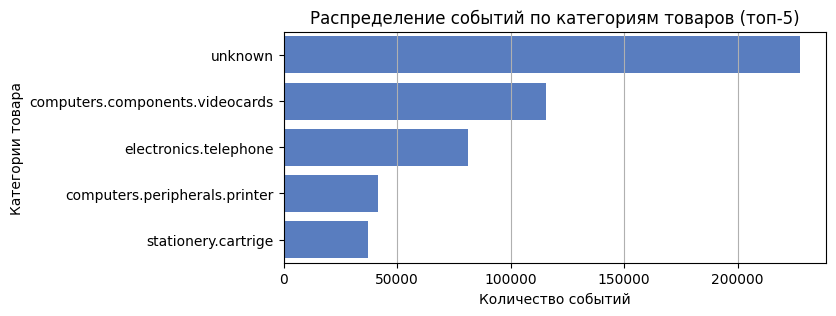

In [28]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Настраиваем палитру
palette = sns.color_palette('muted')

# Строим столбчатую диаграмму
sns.barplot(data=market_df['category_code'].value_counts().sort_values(ascending=False).head().reset_index(),
            x='count',
            y='category_code',
            color=palette[0])

# Настраиваем подписи
plt.title('Распределение событий по категориям товаров (топ-5)')
plt.xlabel('Количество событий')
plt.ylabel('Категории товара')

# Добавляем сетку
plt.grid(axis="x")

# Выводим график
plt.show()

Около 26,6% записей не содержат информации о категории товара, что может затруднить анализ по категориям. Из известных категорий пользователей больше всего интересуют видеокатры (13,5% всех событий), за ними идут телефоны (9,5%), далее принтеры (4,9%). Замыкают топ-5 категорий картриджи с 4,3% записей. 

In [29]:
# Выводим количество уникальных брендов
market_df['brand'].nunique()

997

В датасете представлены 996 уникальных брендов  и `unknown`. Посмотрим, какими брендами пользователи интересуются больше всего.

In [30]:
# Проверяем распределение в абсолютных значениях (топ-5)
market_df['brand'].value_counts().sort_values(ascending=False).head()

brand
unknown     204827
gigabyte     27274
asus         26967
palit        24741
msi          24611
Name: count, dtype: int64

In [31]:
# Проверяем распределение в относительных значениях (топ-5)
market_df['brand'].value_counts(normalize=True).sort_values(ascending=False).head() * 100

brand
unknown     23.921178
gigabyte     3.185255
asus         3.149401
palit        2.889433
msi          2.874251
Name: proportion, dtype: float64

Около 24% записей не содержат информации о бренде, что может затруднить анализ по брендам. На оставшиеся бренды из топ-5 приходится около 12% событий, причём интерес между ними распределён относительно равномерно (около 3% событий). К этим брендам относятся `gigabyte`, `palit`, `asus`, `msi`.

---

### Анализ числовых данных

In [32]:
# Изучаем статистические показатели 
market_df['price'].describe()

count    856258.000000
mean        147.272804
std         295.951184
min           0.220000
25%          26.510000
50%          66.430000
75%         192.860000
max       64771.060000
Name: price, dtype: float64

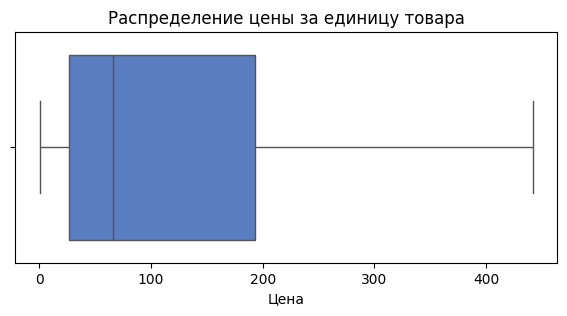

In [33]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Настраиваем палитру
palette = sns.color_palette('muted')

# Строим диаграмму размаха
sns.boxplot(data=market_df, 
            x='price',
            color=palette[0],
            showfliers=False)

# Настраиваем подписи
plt.title('Распределение цены за единицу товара')
plt.xlabel('Цена')

# Выводим график
plt.show()

Средняя цена товара составляет около 147,3, медиана — 66,4: большинство товаров стоят относительно недорого, но встречаются единичные дорогие позиции. Минимальная цена — 0,22, максимальная — 64 771, что может говорить о наличии выбросов и широкого диапазона цен. 25-й и 75-й перцентили (26,51 и 192,86) показывают, что половина товаров стоит в диапазоне примерно от 26 до 193, а остальные — значительно дешевле или дороже. Верхний порог без выбросов составляет около 450. При дальнейшем анализе важно учитывать большой разброс и возможное влияние экстремальных цен на средние показатели.

---

### Промежуточные выводы по исследовательскому анализу

По результатам исследовательского анализа можно сделать следующие выводы:

1. В датасете три типа событий — просмотр, добавление в корзину и покупка. Для дальнейшего анализа важно оценить конверсию между этими этапами.

2. В датасете 107 уникальных категории. Категории имеют иерархическую структуру и состоят из нескольких уровней, разделённых точкой. Пользователей больше всего интересуют видеокатры (13,5% событий), телефоны (9,5%), принтеры (4,9%) и картриджи (4,3%). Здесь мы оцениваем интерес (количество событий), анализ выручки и покупок проведём отдельно.

3. В датасете 996 уникальных брендов. Четыре ведущих (`gigabyte`, `palit`, `asus`, `msi`) суммарно охватывают 12% событий, интерес распределён относительно равномерно.

4. Средняя цена сильно выше медианы (147,3 против 66,4) — значит, большинство товаров недорогие, а распределение тянут вверх редкие дорогие позиции. Типичный диапазон цен — 26,5–192,9, без выбросов — до ~450. Для дальнейшего анализа важно учитывать широкий разброс цен и влияние экстремальных значений на средние показатели.

5. В датасете 26,7% записей не содержат информации о категории и ок. 24% не содержат информации о бренде, что затрудняет анализ по этим признакам.

---

## Решение аналитических задач

### Активность по дням и часам

В этом разделе узнаем, в какие дни недели и часы пользователи тратят и покупают больше и меньше всего. Результаты помогут эффективнее планировать маркетинговые активности.

In [34]:
# Агрегация в разрезе день-день недели
market_day_dow_agg = market_df[market_df['event_type'] == 'purchase'].groupby(['day', 'dow']).agg(
    revenue=('price', 'sum'),
    order_count=('user_session', 'nunique')
).reset_index()

# Проверяем результат
market_day_dow_agg.head()

,day,dow,revenue,order_count
0,2020-10-01,Thursday,18772.03,128
1,2020-10-02,Friday,20942.29,121
2,2020-10-03,Saturday,14502.88,89
3,2020-10-04,Sunday,16810.58,118
4,2020-10-05,Monday,18205.91,138


In [35]:
# Среднее по дням недели за все дни
market_weekly_cycle = market_day_dow_agg.groupby('dow').agg(
    avg_revenue=('revenue', 'mean'),
    avg_order_count=('order_count', 'mean')
).reset_index()

# Округляем
market_weekly_cycle['avg_revenue'] = round(market_weekly_cycle['avg_revenue'], 2)
market_weekly_cycle['avg_order_count'] = round(market_weekly_cycle['avg_order_count']).astype(int)

# Задаём правильный порядок дней недели
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
market_weekly_cycle = market_weekly_cycle.set_index('dow').loc[weekday_order].reset_index()

# Проверяем результат
market_weekly_cycle

,dow,avg_revenue,avg_order_count
0,Monday,36018.45,176
1,Tuesday,34890.17,172
2,Wednesday,33907.68,172
3,Thursday,32957.39,161
4,Friday,32716.31,155
5,Saturday,30123.76,144
6,Sunday,32730.65,148


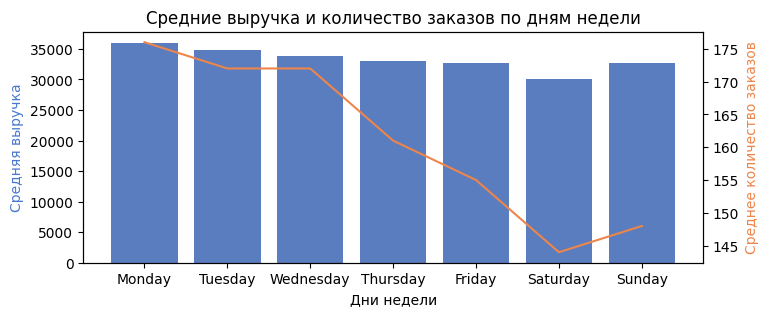

In [58]:
# Создаём контейнер графика
fig, ax1 = plt.subplots(figsize=(8, 3))

# Настраиваем палитру
palette = sns.color_palette('muted')
color_bar = palette[0]  # первый цвет для баров
color_line = palette[1]  # второй цвет для линии

# График средней выручки
sns.barplot(data=market_weekly_cycle, 
            x='dow', 
            y='avg_revenue', 
            ax=ax1, 
            color=color_bar)
ax1.set_xlabel('Дни недели')
ax1.set_ylabel('Средняя выручка', color=color_bar)
ax1.tick_params(axis='y')

# График среднего количества заказов
ax2 = ax1.twinx()
sns.lineplot(data=market_weekly_cycle, 
             x='dow', 
             y='avg_order_count', 
             ax=ax2, 
             color=color_line)
ax2.set_ylabel('Среднее количество заказов', color=color_line)
ax2.tick_params(axis='y')

# Настраиваем заголовок
plt.title('Средние выручка и количество заказов по дням недели')

# Выводим график
plt.show()

Активность пользователей и выручка выше в начале недели (с понедельника по среду), а к выходным постепенно снижается. В понедельник средняя выручка составляет 36 018 при 176 заказах, во вторник — 34 890 и 172 заказа, а в субботу показатели снижаются до 30 124 и 144 заказа. Воскресенье немного выше субботы — 32 731 при 148 заказах.

Посмотрим, есть ли разница в дневной цикличности в будни и выходные дни.

In [37]:
# Будни
# --------

# Агрегация в разрезе день-час
market_day_hour_agg_weekday = market_df[(market_df['event_type'] == 'purchase') & (market_df['is_weekend'] == 0)].groupby(['day', 'hour']).agg(
    revenue=('price', 'sum'),
    order_count=('user_session', 'nunique')
).reset_index()

# Проверяем результат
market_day_hour_agg_weekday.head()

,day,hour,revenue,order_count
0,2020-10-01,0,156.34,3
1,2020-10-01,1,66.10,1
2,2020-10-01,3,118.82,2
3,2020-10-01,4,15.92,1
4,2020-10-01,5,782.32,7


In [38]:
# Среднее по часам за все дни
market_daily_cycle_weekday = market_day_hour_agg_weekday.groupby('hour').agg(
    avg_revenue=('revenue', 'mean'),
    avg_order_count=('order_count', 'mean')
).reset_index()

# Округляем
market_daily_cycle_weekday['avg_revenue'] = round(market_daily_cycle_weekday['avg_revenue'], 2)
market_daily_cycle_weekday['avg_order_count'] = round(market_daily_cycle_weekday['avg_order_count']).astype(int)

# Проверяем результат
market_daily_cycle_weekday

,hour,avg_revenue,avg_order_count
0,0,575.62,2
1,1,472.28,2
2,2,421.99,2
3,3,658.75,3
4,4,704.89,4
5,5,1097.21,6
6,6,1613.34,9
7,7,1692.57,10
8,8,1874.32,11
9,9,1997.91,12


In [39]:
# Выходные
# --------

# Агрегация в разрезе день-час
market_day_hour_agg_weekend = market_df[(market_df['event_type'] == 'purchase') & (market_df['is_weekend'] == 1)].groupby(['day', 'hour']).agg(
    revenue=('price', 'sum'),
    order_count=('user_session', 'nunique')
).reset_index()

# Проверяем результат
market_day_hour_agg_weekend.head()

,day,hour,revenue,order_count
0,2020-10-03,0,489.72,1
1,2020-10-03,1,204.29,1
2,2020-10-03,3,265.26,3
3,2020-10-03,4,571.64,4
4,2020-10-03,5,489.04,3


In [40]:
# Среднее по часам за все дни
market_daily_cycle_weekend = market_day_hour_agg_weekend.groupby('hour').agg(
    avg_revenue=('revenue', 'mean'),
    avg_order_count=('order_count', 'mean')
).reset_index()

# Округляем
market_daily_cycle_weekend['avg_revenue'] = round(market_daily_cycle_weekend['avg_revenue'], 2)
market_daily_cycle_weekend['avg_order_count'] = round(market_daily_cycle_weekend['avg_order_count']).astype(int)

# Проверяем результат
market_daily_cycle_weekend

,hour,avg_revenue,avg_order_count
0,0,743.43,2
1,1,368.01,2
2,2,462.85,2
3,3,514.46,2
4,4,618.28,3
5,5,810.69,5
6,6,1121.57,6
7,7,1714.06,8
8,8,1477.56,9
9,9,1919.91,10


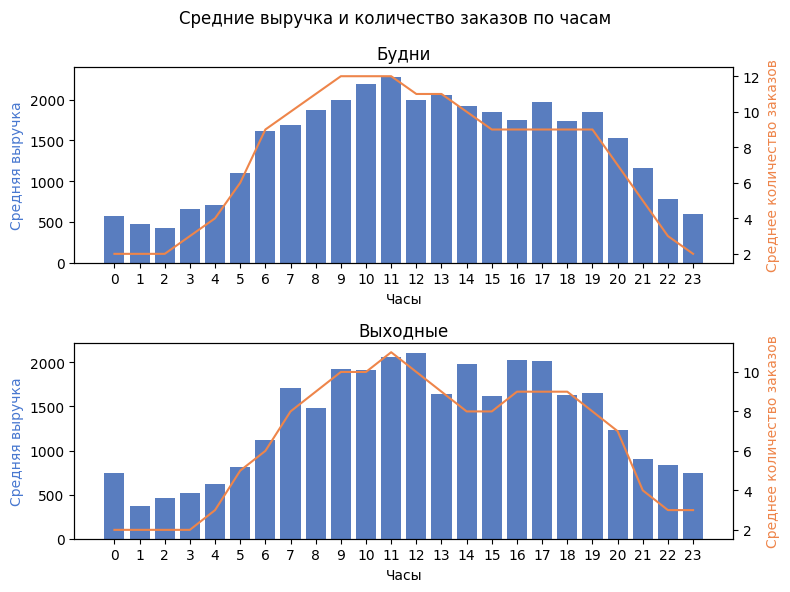

In [62]:
# Создаём контейнер графика (2 х 1) и задаём его размер
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Общий заголовок
fig.suptitle('Средние выручка и количество заказов по часам')

# Настраиваем палитру
palette = sns.color_palette('muted')
color_bar = palette[0]
color_line = palette[1]

# -------------------
# Первый график (будни)
# -------------------
# График средней выручки
ax1 = axes[0]
sns.barplot(
    data=market_daily_cycle_weekday,
    x='hour',
    y='avg_revenue',
    ax=ax1,
    color=color_bar
)
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средняя выручка', color=color_bar)
ax1.tick_params(axis='y')

# График среднего количества заказов
ax1_line = ax1.twinx()
sns.lineplot(
    data=market_daily_cycle_weekday,
    x='hour',
    y='avg_order_count',
    ax=ax1_line,
    color=color_line
)
ax1_line.set_ylabel('Среднее количество заказов', color=color_line)
ax1_line.tick_params(axis='y')

ax1.set_title('Будни')

# -------------------
# Второй график (выходные)
# -------------------
# График средней выручки
ax2 = axes[1]
sns.barplot(
    data=market_daily_cycle_weekend,
    x='hour',
    y='avg_revenue',
    ax=ax2,
    color=color_bar
)
ax2.set_xlabel('Часы')
ax2.set_ylabel('Средняя выручка', color=color_bar)
ax2.tick_params(axis='y')

# График среднего количества заказов
ax2_line = ax2.twinx()
sns.lineplot(
    data=market_daily_cycle_weekend,
    x='hour',
    y='avg_order_count',
    ax=ax2_line,
    color=color_line
)
ax2_line.set_ylabel('Среднее количество заказов', color=color_line)
ax2_line.tick_params(axis='y')

ax2.set_title('Выходные')

# Настраиваем отступы между графиками
plt.tight_layout()

# Выводим график
plt.show()

По графикам можно сделать следующие выводы:

1. Будни:
    - Пик среднего числа заказов и выручки приходится на 9–11 часов. Максимум 12 заказов, выручка до 2,3 тыс.
    - После 11 часов выручка и заказы постепенно снижаются, а после 19 часов начинается резкий спад.
2. Выходные:
    - Пик заказов и выручки смещён на 11–12 часов. Максимум 11 заказов, выручка до 2,1 тыс.
    - Второй небольшой всплеск наблюдается в 16–17 часов. Максимум 9 заказов, выручка до 2 тыс.
    - После 18 начинается спад заказов и выручки.

**Главное:**
В оба типа дней утро и ранний день (9-12 часов) — пиковый период активности. В выходные пик активности смещён на чуть более позднее время (11-12), а заказы и выручка распределены более равномерно в течение дня, с небольшим вечерним пиком. Вечерние часы менее активны — и в будни, и в выходные после 18-19 начинается резкий спад.

---

### Анализ продуктовой воронки

Раздел посвящён анализу продуктовой воронки: мы изучим, как пользователи проходят ключевые этапы — от просмотра до покупки. Помесячная динамика конверсий покажет общие тенденции, а анализ уникальных комбинаций событий (`view`, `cart`, `purchase`) в рамках одной сессии позволит выявить типовые сценарии и определить этапы потерь аудитории.

In [42]:
# Создаём сводную таблицу
user_count_pivot = pd.pivot_table(
    data=market_df,
    values='user_id',
    index='month',      
    columns='event_type',
    aggfunc='nunique',
    fill_value=0
).reset_index()

# Сбрасываем имя индекса
user_count_pivot.columns.name = None

# Задаём правильный порядок месяцов
month_order = ['October','November','December','January','February']
user_count_pivot = user_count_pivot.set_index('month').loc[month_order].reset_index()

# Задаём правильную очерёдность колонок
user_count_pivot = user_count_pivot[['month', 'view', 'cart', 'purchase']]

# Считаем конверсии
user_count_pivot['view_to_cart'] = round(user_count_pivot['cart'] * 100.0 / user_count_pivot['view'], 2)
user_count_pivot['cart_to_purchase'] = round(user_count_pivot['purchase'] * 100.0 / user_count_pivot['cart'], 2)
user_count_pivot['view_to_purchase'] = round(user_count_pivot['purchase'] * 100.0 / user_count_pivot['view'], 2)

# Проверяем результат
user_count_pivot

,month,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
0,October,84096,6424,3796,7.64,59.09,4.51
1,November,92529,7433,4328,8.03,58.23,4.68
2,December,72074,6650,3869,9.23,58.18,5.37
3,January,81154,8515,4771,10.49,56.03,5.88
4,February,74506,7725,4341,10.37,56.19,5.83


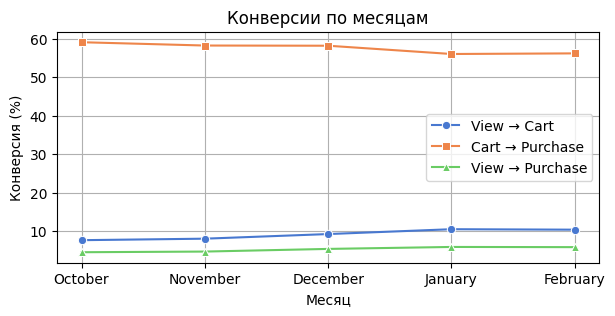

In [64]:
# Создаём контейнер графика
plt.figure(figsize=(7, 3))

# Настраиваем палитру
palette = sns.color_palette('muted')

# График конверсии View → Cart
sns.lineplot(data=user_count_pivot, 
             x='month', 
             y='view_to_cart', 
             marker='o', 
             label='View → Cart',
             color=palette[0])

# График конверсии Cart → Purchase
sns.lineplot(data=user_count_pivot, 
             x='month', 
             y='cart_to_purchase', 
             marker='s', 
             label='Cart → Purchase',
             color=palette[1])

# График конверсии View → Purchase
sns.lineplot(data=user_count_pivot, 
             x='month', 
             y='view_to_purchase', 
             marker='^', 
             label='View → Purchase',
             color=palette[2])

# Настраиваем подписи
plt.title('Конверсии по месяцам')
plt.ylabel('Конверсия (%)')
plt.xlabel('Месяц')

# Настраиваем сетку
plt.grid(True)

# Выводим легенду
plt.legend()

# Выводим график
plt.show()

По графику можно сделать следующие выводы:

- Больше всего покупателей (от 90 до 92%) теряется на этапе `View → Cart`. Большинство пользователей просматривают товары, но пока не готовы их добавить в корзину — возможно, они исследуют ассортимент, сравнивают цены или ищут вдохновение. Тем не менее, со временем конверсия `View → Cart` растёт — с 7,64% в октябре до 10,37% в феврале.

- На этапе `Cart → Purchase` конверсия составляет 56–59%. Более половины пользователей, положивших товар в корзину, в итоге его купили. Однако со временем показатель снижается — с 59,09% в октябре до 56,19% в феврале. Интересно, что снижение происходит на фоне роста интереса пользователей к товарам (`View → Cart`), и даже 11.11 и зимние праздники не остановили падение. Возможно, пользователи становятся более избирательными, откладывают покупку или сравнивают предложения, прежде чем завершить заказ.

- Общая конверсия `View → Purchase` демонстрирует постепенный рост — с 4,51% в октябре до 5,83% в феврале. Рост есть, но он ограничен падением конверсии на этапе `Cart → Purchase`. Это указывает на необходимость улучшений в процессе оформления заказа, чтобы удерживать пользователей, дошедших до корзины.

**Главное:** На этапе `View → Cart` теряется большая часть аудитории (90–92%), но конверсия постепенно растёт. Более половины пользователей, добавивших товар в корзину, его покупают, однако наблюдается снижение конверсии с 59,1% в октябре до 56,2% в феврале. Это показывает необходимость улучшений как на этапе добавления товаров в корзину, так и при оформлении заказа. Общая конверсия `View → Purchase` растёт (с 4,51% в октябре до 5,83% в феврале), в основном за счёт увеличения интереса к товарам на этапе `View → Cart`.

Помесячная динамика конверсий показывает общий тренд и изменения эффективности воронки во времени, но не отражает поведение пользователей в рамках одной сессии. Выделим уникальные комбинации событий (`view`, `cart`, `purchase`) и подсчитаем их частоту, чтобы выявить типовые сценарии и определить, на каких этапах теряется аудитория.

In [44]:
# Выделяем уникальные комбинации событий
session_funnels = market_df.groupby('user_session')['event_type'].apply(set)

# Подсчитываем частоту каждой комбинации
session_funnels = session_funnels.value_counts().reset_index()

# Переименовываем столбцы
session_funnels.columns = ['user_journey', 'session_count']

# Рассчитываем процент от общего числа сессий
session_funnels['session_percent'] = round(session_funnels['session_count'] / session_funnels['session_count'].sum() * 100, 2)

# Проверяем результат
session_funnels

,user_journey,session_count,session_percent
0,{view},430186,90.79
1,"{view, cart, purchase}",20190,4.26
2,"{view, cart}",19962,4.21
3,{purchase},1971,0.42
4,"{view, purchase}",1514,0.32
5,"{cart, purchase}",6,0.00
6,{cart},6,0.00


По получившейся таблице можно сделать следующие выводы:

- Большинство сессий ограничиваются только просмотром товаров — 430 186 сессий (90,79%) содержат исключительно событие `view`.
- Полный путь до покупки (`view` → `cart` → `purchase`) встречается относительно редко — 20 190 сессий (4,26%), хотя именно эти сценарии формируют выручку.
- Добавление в корзину без покупки (`view` → `cart`) встречается почти так же часто — 19 962 сессии (4,21%), что говорит о высоком уровне незавершённых покупок.
- Сессии с прямой покупкой без просмотра и корзины (`purchase`) крайне редки — 1 971 сессия (0,42%).
- Сценарии `view` → `purchase` также встречаются редко — 1 514 сессий (0,32%) и, вероятно, связаны с быстрыми покупками («Купить в 1 клик») или особенностями трекинга.
- Комбинации `cart` → `purchase` и `cart` встречаются по 6 раз и, скорее всего, являются артефактами данных, так как добавление в корзину без просмотра товара маловероятно.

**Главное:** Основные проблемы — потеря пользователей на этапе добавления в корзину и большое количество «брошенных корзин». 90,79% сессий ограничиваются только просмотром, а 4,21% включают добавление в корзину без покупки. Это подтверждает необходимость улучшений как на этапе добавления в корзину, так и на этапе оформления заказа. 

---

### Анализ категорий товаров

В этом разделе мы рассмотрим, какие категории товаров приносят магазину наибольшую и наименьшую выручку, а также проанализируем коэффициент конверсии по категориям. Это позволит понять, на каких категориях стоит сосредоточить маркетинговые усилия, где есть потенциал для роста конверсии, а от каких категорий, возможно, имеет смысл отказаться.

Категории товаров в датасете имеют иерархическую структуру из нескольких уровней, разделённых точкой (например, `computers.components.videocards`). Для первичного анализа имеет смысл агрегировать данные на уровне первого уровня категорий. Это позволяет снизить детализацию и посмотреть на картину в целом: какие крупные товарные направления вносят наибольший вклад в выручку и конверсию, а какие работают хуже. Такой подход поможет выделить ключевые драйверы бизнеса и категории-аутсайдеры.

In [45]:
# Добавляем столбец с верхнеуровневой категорией
market_df['category_level_1'] = market_df['category_code'].str.split('.').str[0]

# Проверяем результат
market_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,hour,dow,is_weekend,category_level_1
28074,2020-10-01 00:01:36+00:00,view,1795171,2144415922360680550,computers.peripherals.camera,canyon,39.75,1515915625520113390,4x2nwiinsi,October,2020-10-01,0,Thursday,0,computers
28075,2020-10-01 00:04:11+00:00,view,1549819,2144415925011480748,stationery.cartrige,xerox,69.35,1515915625521278799,dam8ubpofo,October,2020-10-01,0,Thursday,0,stationery
28076,2020-10-01 00:07:23+00:00,view,4156248,2144415921169498184,unknown,unknown,17.14,1515915625521278938,edgysorbdc,October,2020-10-01,0,Thursday,0,unknown
28077,2020-10-01 00:07:56+00:00,view,16101,2144415922360680550,computers.peripherals.camera,unknown,30.38,1515915625520113390,4x2nwiinsi,October,2020-10-01,0,Thursday,0,computers
28078,2020-10-01 00:08:11+00:00,view,880508,2144415926806642904,computers.components.power_supply,cougar,57.13,1515915625521279091,et4gwstgmb,October,2020-10-01,0,Thursday,0,computers


In [46]:
# Создаём таблицу с основными метриками по верхнеуровневым категориям
level_1_main_data = (
    market_df[market_df['event_type'] == 'purchase']
        .groupby('category_level_1')
        .agg(revenue=('price', 'sum'), orders=('user_session', 'nunique'))
        .reset_index()
        .sort_values(by='revenue', ascending=False, ignore_index=True)
)

# Добавляем новые столбцы
level_1_main_data['revenue_share'] = level_1_main_data['revenue'] * 100.0 / level_1_main_data['revenue'].sum()
level_1_main_data['aov'] = round(level_1_main_data['revenue'] / level_1_main_data['orders'], 2)

# Задаём правильную очерёдность колонок
level_1_main_data = level_1_main_data[['category_level_1', 'revenue', 'revenue_share', 'orders', 'aov']]

# Проверяем результат
level_1_main_data

,category_level_1,revenue,revenue_share,orders,aov
0,computers,3673227.18,73.044379,10720,342.65
1,unknown,479807.86,9.541274,5106,93.97
2,electronics,434201.37,8.634361,4539,95.66
3,auto,114371.53,2.274348,719,159.07
4,construction,107981.98,2.147288,645,167.41
5,stationery,105334.05,2.094632,1678,62.77
6,appliances,102895.00,2.046130,600,171.49
7,country_yard,4318.45,0.085875,17,254.03
8,accessories,2046.90,0.040704,37,55.32
9,furniture,2023.71,0.040243,82,24.68


In [47]:
# Создаём таблицу с уникальными пользователями по типу события
level_1_cr = pd.pivot_table(
    data=market_df,
    values='user_id',
    index='category_level_1',      
    columns='event_type',
    aggfunc='nunique',
    fill_value=0
).reset_index()

# Сбрасываем имя индекса
level_1_cr.columns.name = None

# Задаём правильную очерёдность колонок
level_1_cr = level_1_cr[['category_level_1', 'view', 'cart', 'purchase']]

# Считаем конверсии
level_1_cr['view_to_cart'] = round(level_1_cr['cart'] * 100.0 / level_1_cr['view'], 2)
level_1_cr['cart_to_purchase'] = round(level_1_cr['purchase'] * 100.0 / level_1_cr['cart'], 2)
level_1_cr['view_to_purchase'] = round(level_1_cr['purchase'] * 100.0 / level_1_cr['view'], 2)

# Проверяем результат
level_1_cr

,category_level_1,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
0,accessories,1120,52,32,4.64,61.54,2.86
1,apparel,82,1,0,1.22,0.00,0.00
2,appliances,21442,901,540,4.20,59.93,2.52
3,auto,16468,1102,612,6.69,55.54,3.72
4,computers,112258,16712,9204,14.89,55.07,8.20
5,construction,14375,1015,550,7.06,54.19,3.83
6,country_yard,1576,37,17,2.35,45.95,1.08
7,electronics,86565,6776,4014,7.83,59.24,4.64
8,furniture,1822,122,72,6.70,59.02,3.95
9,jewelry,170,10,4,5.88,40.00,2.35


In [48]:
# Объединяем таблицы
level_1_union_table = pd.merge(level_1_main_data, level_1_cr, on='category_level_1')

# Проверяем результат
level_1_union_table

,category_level_1,revenue,revenue_share,orders,aov,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
0,computers,3673227.18,73.044379,10720,342.65,112258,16712,9204,14.89,55.07,8.20
1,unknown,479807.86,9.541274,5106,93.97,124965,7862,4613,6.29,58.67,3.69
2,electronics,434201.37,8.634361,4539,95.66,86565,6776,4014,7.83,59.24,4.64
3,auto,114371.53,2.274348,719,159.07,16468,1102,612,6.69,55.54,3.72
4,construction,107981.98,2.147288,645,167.41,14375,1015,550,7.06,54.19,3.83
5,stationery,105334.05,2.094632,1678,62.77,22322,2232,1498,10.00,67.11,6.71
6,appliances,102895.00,2.046130,600,171.49,21442,901,540,4.20,59.93,2.52
7,country_yard,4318.45,0.085875,17,254.03,1576,37,17,2.35,45.95,1.08
8,accessories,2046.90,0.040704,37,55.32,1120,52,32,4.64,61.54,2.86
9,furniture,2023.71,0.040243,82,24.68,1822,122,72,6.70,59.02,3.95


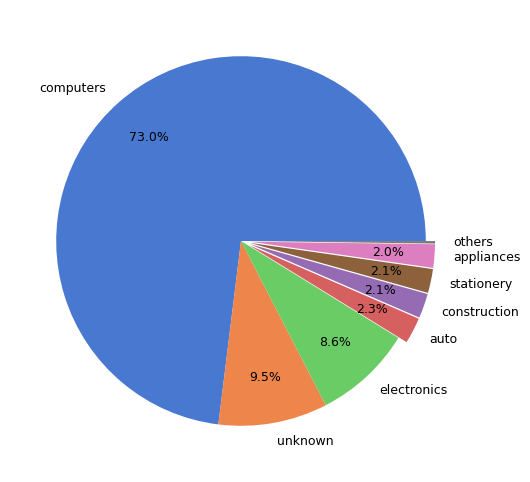

In [65]:
# Разделяем категории: >= 2% и < 2%
level_1_large = level_1_union_table[level_1_union_table['revenue_share'] >= 2].copy()
level_1_small = level_1_union_table[level_1_union_table['revenue_share'] < 2].copy()

# Группируем категории с долей выручки < 2% в категорию «Others»
level_1_others = pd.DataFrame({
    'category_level_1': ['others'],
    'revenue': [level_1_small['revenue'].sum()],
    'revenue_share': [level_1_small['revenue_share'].sum()]
})

# Объединяем таблицы
level_1_plot = pd.concat([level_1_large, level_1_others], ignore_index=True)

# Задаем контейнер графика
plt.figure(figsize=(10, 6))

# Настраиваем палитру
palette = sns.color_palette('muted')

# Раздвигаем небольшие сектора
explode = [
    0.05 if share < 3 else 0
    for share in level_1_plot['revenue_share']
]

# Не показываем проценты для мелких сегментов
def autopct_if_big(pct):
    return f'{pct:.1f}%' if pct >= 2 else ''

# Строим круговую диаграмму
plt.pie(
    level_1_plot['revenue_share'],
    labels=level_1_plot['category_level_1'],
    autopct=autopct_if_big,
    explode=explode,
    pctdistance=0.75,
    textprops={'fontsize': 9},
    colors=palette
)

# Настраиваем подпись
plt.title('Структура выручки по верхнеуровневым категориям')

# Выводим график
plt.show()

По диаграмме можно сделать следующие выводы:
- Топовые категории: `computers` (73% выручки) и `electronics` (8,6% выручки).
- Категории `auto`, `construction`, `stationery`, `appliances` приносят ок. 2% выручки каждая.
- Категории-аутсайдеры: `country_yard`, `accessories`, `furniture`, `sport`, `medicine`, `kids`, `jewelry`. В сумме эти категории приносят 0,2% выручки (раздел `others` на графике).


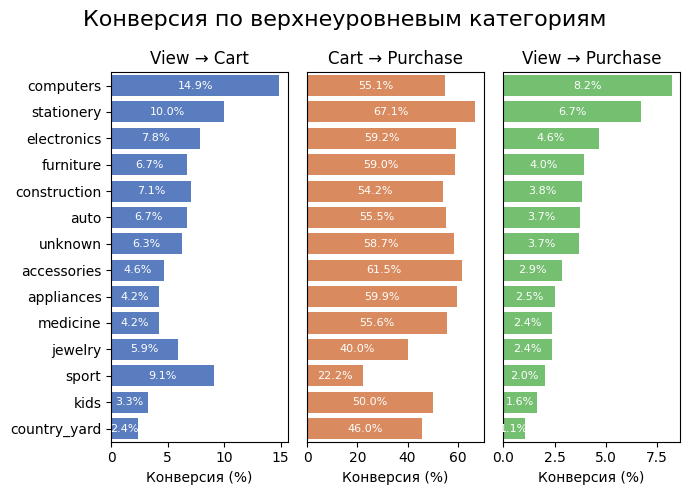

In [67]:
# Создаём контейнер графика (1 х 3) и задаём его размер
fig, axes = plt.subplots(1, 3, figsize=(7, 5))

# Настраиваем палитру
palette = sns.color_palette('muted')

# Общий заголовок для всей фигуры
fig.suptitle('Конверсия по верхнеуровневым категориям', fontsize=16)

# Настраиваем единый порядок категорий — по итоговой конверсии
order = level_1_union_table.sort_values('view_to_purchase', ascending=False)['category_level_1']

# Функция для подписей
def add_labels(ax):
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt='%.1f%%',
            label_type='center',
            fontsize=8,
            color='white'
        )

# График View → Cart
sns.barplot(
    data=level_1_union_table,
    y='category_level_1',
    x='view_to_cart',
    order=order,
    color=palette[0],
    ax=axes[0],
    orient='h'
)
axes[0].set_title('View → Cart', fontsize=12)
axes[0].set_xlabel('Конверсия (%)')
axes[0].set_ylabel('')
add_labels(axes[0])

# График Cart → Purchase
sns.barplot(
    data=level_1_union_table,
    y='category_level_1',
    x='cart_to_purchase',
    order=order,
    color=palette[1],
    ax=axes[1],
    orient='h'
)
axes[1].set_title('Cart → Purchase', fontsize=12)
axes[1].set_xlabel('Конверсия (%)')
axes[1].set_ylabel('')
add_labels(axes[1])
axes[1].tick_params(left=False, labelleft=False)

# График View → Purchase
sns.barplot(
    data=level_1_union_table,
    y='category_level_1',
    x='view_to_purchase',
    order=order,
    color=palette[2],
    ax=axes[2],
    orient='h'
)
axes[2].set_title('View → Purchase', fontsize=12)
axes[2].set_xlabel('Конверсия (%)')
axes[2].set_ylabel('')
add_labels(axes[2])
axes[2].tick_params(left=False, labelleft=False)

# Настраиваем отступы
plt.tight_layout()

# Выводим графики
plt.show()

По графику можно сделать следующие выводы:
- `computers`: показывает самую высокую общую конверсию (8,2%), в основном за счет высокой конверсии `View → Cart`. Есть потенциал к повышению конверсии `Cart → Purchase`.
- `stationery`: на втором месте по общей конверсии (6,7%) за счёт высокой конверсии на шаге `Cart → Purchase`. Нужно работать над повышением конверсии `View → Cart`.
- `electronics`: показывает неплохую общую конверсию (4,6%), но есть проседание на шаге `View → Cart`.
- `furniture`: хотя приносит менее 1% выручки, общая конверсия неплохая (4%) за счёт высокой конверсии `Cart → Purchase`. Можно чаще предлагать как дополнение к покупке.
- `constraction` и `auto`: общие конверсии ниже среднего (3,8% и 3,7%), есть проседание на шаге `View → Cart` и потенциал роста на шаге `Cart → Purchase`.
- `accessories`: хотя приносит менее 1% выручки, конверсия `Cart → Purchase` очень хорошая (61,5%). Имеет смысл чаще предлагать как дополнение к покупке, как и `furniture`.
- `appliances`: хотя категория не худшая по выручке, общая конверсия очень низкая (2,5%). Основное проседание на шаге `View → Cart`.
- `medicine`, `jewelry`, `sport`, `kids`, `country_yard`: категории с низкой выручкой и низкой общей конверсией (менее 2,5%).

**Главное (верхнеуровневые категории):**
1. Топовые верхнеуровневые категории:
    - `computers`: 73% выручки, 8,2% общая конверсия. Стоит поработать над шагом `Cart → Purchase` (55,1%).
    - `electronics`: 8,6% выручки, 4,6% общая конверсия. Стоит поработать над шагом `View → Cart` (7,8%).
    - `stationery`: 2,1% выручки, но при этом 6,7% общая конверсия. Стоит поработать над шагом `View → Cart` (10%).
2. Средние верхнеуровневые категории:
    - `auto`: 2,3% выручки, 3,7% общая конверсия. Стоит в первую очередь работать над шагом `View → Cart` (6,7%), на шаге `Cart → Purchase` (55,5%) также есть потенциал роста.
    - `construction`: 2,1% выручки, 3,8% общая конверсия. Стоит в первую очередь работать над `View → Cart` (7,1%), на шаге `Cart → Purchase` (54,2%) также есть потенциал роста.
    - `appliances`: 2% выручки, всего 2,5% общая конверсия. Хорошая конверсия на `Cart → Purchase` (59,9%), но очень низкая на `View → Cart` (4,2%).
3. Верхнеуровневые категории-аутсайдеры:
    - `furniture` и `accessories`: приносят по 0,04% выручки, но имеют хорошие конверсии `Cart → Purchase` (59% и 61,5%). Имеет смысл предлагать как дополнение к покупке.
    - `medicine`, `jewelry`, `sport`, `kids`, `country_yard`: минимум выручки при низкой конверсии. Рекомендуется оптимизировать запасы или убрать из товарной линейки.

Далее углубимся на уровень подкатегорий и посмотрим, какие товарные группы показывают наилучший результат по выручке и конверсии. Сосредоточимся на топ-10 по выручке.

In [51]:
# Создаём таблицу с основными метриками по подкатегориям
category_main_data = (
    market_df[market_df['event_type'] == 'purchase']
        .groupby('category_code')
        .agg(revenue=('price', 'sum'), orders=('user_session', 'nunique'))
        .reset_index()
        .sort_values(by='revenue', ascending=False, ignore_index=True)
)

# Добавляем новые столбцы
category_main_data['revenue_share'] = category_main_data['revenue'] * 100.0 / category_main_data['revenue'].sum()
category_main_data['aov'] = round(category_main_data['revenue'] / category_main_data['orders'], 2)

# Задаём правильную очерёдность колонок
category_main_data = category_main_data[['category_code', 'revenue', 'revenue_share', 'orders', 'aov']]

# Создаём таблицу с уникальными пользователями по типу события
category_cr = pd.pivot_table(
    data=market_df,
    values='user_id',
    index='category_code',      
    columns='event_type',
    aggfunc='nunique',
    fill_value=0
).reset_index()

# Сбрасываем имя индекса
category_cr.columns.name = None

# Задаём правильную очерёдность колонок
category_cr = category_cr[['category_code', 'view', 'cart', 'purchase']]

# Считаем конверсии
category_cr['view_to_cart'] = round(category_cr['cart'] * 100.0 / category_cr['view'], 2)
category_cr['cart_to_purchase'] = round(category_cr['purchase'] * 100.0 / category_cr['cart'], 2)
category_cr['view_to_purchase'] = round(category_cr['purchase'] * 100.0 / category_cr['view'], 2)

# Объединяем таблицы
category_union_table = pd.merge(category_main_data, category_cr, on='category_code')

# Выводим топ-10
category_top_10 = category_union_table.head(10)
category_top_10

,category_code,revenue,revenue_share,orders,aov,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
0,computers.components.videocards,2589248.70,51.488801,4711,549.62,28809,7895,3957,27.40,50.12,13.74
1,unknown,479807.86,9.541274,5106,93.97,124965,7862,4613,6.29,58.67,3.69
2,computers.peripherals.printer,348365.21,6.927456,1669,208.73,19042,2296,1462,12.06,63.68,7.68
3,computers.components.cpu,212639.80,4.228473,812,261.87,9554,1492,666,15.62,44.64,6.97
4,electronics.telephone,146156.96,2.906421,2785,52.48,42252,4061,2475,9.61,60.95,5.86
5,computers.components.motherboard,99813.66,1.984856,856,116.60,9741,1439,720,14.77,50.03,7.39
6,stationery.cartrige,99392.55,1.976482,1589,62.55,20099,2100,1415,10.45,67.38,7.04
7,electronics.audio.acoustic,82102.81,1.632665,544,150.92,12969,858,463,6.62,53.96,3.57
8,auto.accessories.player,79328.73,1.577501,450,176.29,7127,642,375,9.01,58.41,5.26
9,computers.notebook,61582.12,1.224598,929,66.29,12692,1246,831,9.82,66.69,6.55


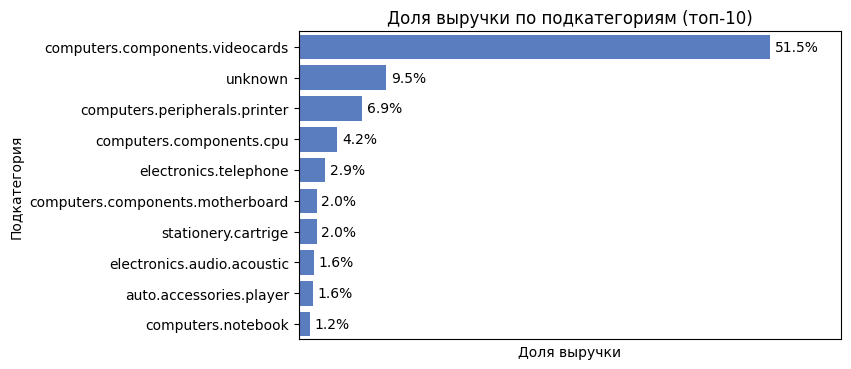

In [69]:
# Создаём контейнер графика
plt.figure(figsize=(7, 4))

# Настраиваем палитру
palette = sns.color_palette('muted')

# Строим столбчатую диаграмму
ax = sns.barplot(data=category_top_10,
                 x='revenue_share',
                 y='category_code',
                 color=palette[0])

# Настраиваем подписи
plt.title('Доля выручки по подкатегориям (топ-10)')
plt.xlabel('Доля выручки')
plt.ylabel('Подкатегория')

# Подписи процентов справа от баров
for index, value in enumerate(category_top_10['revenue_share']):
    plt.text(value + 0.5, index, f'{value:.1f}%', va='center')

# Расширяем предел оси X, чтобы подписи не наезжали
x_max = category_top_10['revenue_share'].max()
plt.xlim(0, x_max * 1.15)

# Убираем отметки на оси X, оставляем линию и подпись
ax.set_xticks([])

# Выводим график
plt.show()

По графику можно сделать следующие выводы:
- Более половины выручки (51,5%) магазину приносят видеокарты.
- На втором месте принтеры с 6,9% выручки.
- Первую тройку замыкают процессоры с 4,2% выручки.
- Телефоны приносят магазину 2,9% выручки.
- Материские платы и картриджи — по 2% выручки.
- Акустически системы и автомагнитолы — по 1,6% выручки.
- Наконец, замыкает десятку ноутбуки с 1,2% выручки.

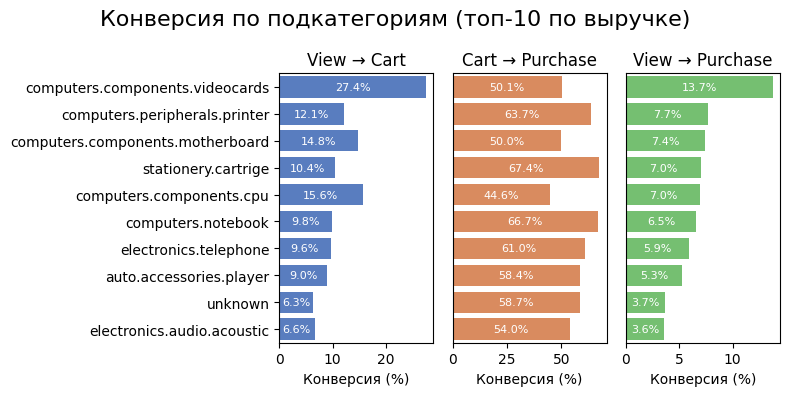

In [71]:
# Создаём контейнер графика (1 х 3) и задаём его размер
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

# Настраиваем палитру
palette = sns.color_palette('muted')

# Общий заголовок для всей фигуры
fig.suptitle('Конверсия по подкатегориям (топ-10 по выручке)', fontsize=16)

# Настраиваем единый порядок категорий — по итоговой конверсии
order = category_top_10.sort_values('view_to_purchase', ascending=False)['category_code']

# Функция для подписей
def add_labels(ax):
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt='%.1f%%',
            label_type='center',
            fontsize=8,
            color='white'
        )

# График View → Cart
sns.barplot(
    data=category_top_10,
    y='category_code',
    x='view_to_cart',
    order=order,
    color=palette[0],
    ax=axes[0],
    orient='h'
)
axes[0].set_title('View → Cart', fontsize=12)
axes[0].set_xlabel('Конверсия (%)')
axes[0].set_ylabel('')
add_labels(axes[0])


# График Cart → Purchase
sns.barplot(
    data=category_top_10,
    y='category_code',
    x='cart_to_purchase',
    order=order,
    color=palette[1],
    ax=axes[1],
    orient='h'
)
axes[1].set_title('Cart → Purchase', fontsize=12)
axes[1].set_xlabel('Конверсия (%)')
axes[1].set_ylabel('')
add_labels(axes[1])
axes[1].tick_params(left=False, labelleft=False)  # скрываем ось Y

# График View → Purchase
sns.barplot(
    data=category_top_10,
    y='category_code',
    x='view_to_purchase',
    order=order,
    color=palette[2],
    ax=axes[2],
    orient='h'
)
axes[2].set_title('View → Purchase', fontsize=12)
axes[2].set_xlabel('Конверсия (%)')
axes[2].set_ylabel('')
add_labels(axes[2])
axes[2].tick_params(left=False, labelleft=False)  # скрываем ось Y

# Настраиваем отступы
plt.tight_layout()

# Выводим графики
plt.show()

По графику можно сделать следующие выводы:
- `computers.components.videocards`: самая высокая общая конверсия (13,7%) за счёт высокой конверсии `View → Cart`. Есть потенциал к повышению конверсии `Cart → Purchase`.
- `computers.peripherals.printer`: на втором месте по общей конверсии (7,7%) за счёт `Cart → Purchase`. Есть потенциал к повышению конверсии `View → Cart`.
- `computers.components.motherboard`: на третьем месте по общей конверсии (7,4%), но есть потенциал роста на шаге `Cart → Purchase`.
- `stationery.cartrige`: показывает наилучшую из всех конверсию `Cart → Purchase` (67,4%), однако проседает на этапе `View → Cart`. Общая конверсия 7%.
- `computers.components.cpu`: вторая по конверсии `View → Cart` (15,6%), однако самый низкий показатель конверсии `Cart → Purchase` (44,6%). Общая конверсия 7%.
- `computers.notebook`: вторая по конверсии `Cart → Purchase`, однако проседает на шаге `View → Cart` (9,8%), в результате общая конверсия 6,5%.
- `electronics.telephone`, `auto.accessories.player`: довольно высокие конверсии `Cart → Purchase`, но при этом проседание `View → Cart`, общие конверсии 5,9% и 5,3%.
- `electronics.audio.acoustic`: самая низкая общая конверсия из топ-10 по выручке (3,6%). Потенциал роста есть как на `View → Cart`, так и на `Cart → Purchase`.

**Главное (топ-10 по выручке):**
1. Подкатегории с наилучшими показателями:
    - `computers.components.videocards`: абсолютный топ по выручке (51,5%) и общей конверсии (13,7%). Стоит поработать над шагом `Cart → Purchase` (50,1%).
    - `computers.peripherals.printer`: на втором месте по выручке (6,9%) и общей конверсии (7,7%). Стоит поработать над шагом `View → Cart` (12,1%).
2. Остальные подкатегории из топ-10 по выручке:
    - `computers.components.cpu`: выручка 4,2%, общая конверсия 7%. Самый низкий в топе показатель конверсии `Cart → Purchase` (44,6%), над ним работать в первую очередь.
    - `electronics.telephone`: выручка 2,9%, общая конверсия 5,9%. Главное проседание на этапе `View → Cart` (9,6%), на нём стоит сосредоточить внимание. У подкатегории самый низкий средний чек из всей десятки (52,48), имеет смысл использовать cross-sell и up-sell для его увеличения.
    - `computers.components.motherboard`: хотя выручка 2%, подкатегория на третьем месте по общей конверсии (7,4%). Стоит уделить внимание этапу `Cart → Purchase`.
    - `stationery.cartrige`: выручка 2%, общая конверсия 7%. Подкатегория с наивысшей конверсией `Cart → Purchase` (67,4%), но можно поработать над  `View → Cart` (10,4%). Например, предлагать картриджи как дополнение к принтеру и напоминать покупателю с определёнными интервалами, что пора докупить расходники. У подкатегории низкий средний чек (62,55), имеет смысл использовать пакетные предложения (комплекты из нескольких картриджей) для его увеличения.
    - `electronics.audio.acoustic`: выручка 1,6%, общая конверсия самая низкая в топе (3,6%). Стоит в первую очередь работать над шагом `View → Cart` (6,6%), на шаге `Cart → Purchase` (54%) также есть потенциал роста.
    - `auto.accessories.player`: выручка 1,6%, общая конверсия 5,3%. Довольно высокая конверсия `Cart → Purchase` (58,4%) при проседании на шаге `View → Cart` (9%).
    - `computers.notebook`: выручка 1,2% (последнее место топ-10), общая конверсия 6,5%. Высокая конверсия `Cart → Purchase` (66,7%) при проседании `View → Cart` (9,8%). У подкатегории низкий средний чек (66,29), имеет смысл использовать cross-sell и up-sell для его увеличения.

---

## Итоговый вывод и рекомендации

### Общий обзор проделанной работы

Проведён анализ пользовательского поведения в онлайн-магазине электроники. Исследование основывалось на логах событий пользователей за 5 месяцев (октябрь 2020 — февраль 2021). В рамках проекта были выполнены следующие шаги:

**1. Предобработка данных:**
- Скорректированы типы данных и оптимизирована разрядность числовых столбцов для снижения потребления памяти.
- Обработаны пропуски в столбцах `user_session`, `brand` и `category_code`.
- Удалено 652 полных дубликата.
- Созданы временные признаки (месяц, дата, час, день недели, выходной).
- Данные отфильтрованы по полным месяцам. Итоговый датасет содержит 856 258 событий (96,7% от исходного объёма).

**2. Исследовательский анализ:**
- Изучена структура датасета: типы событий, распределение интереса пользователей по категориям и брендам, ценовые характеристики.
- Зафиксирована высокая доля неполных данных по категориям (26,6%) и брендам (ок. 24%).

**3. Решение аналитических задач:**
- Проанализирована пользовательская активность во времени: выявлены пиковые дни недели и часы, различия между буднями и выходными.
- Исследована продуктовая воронка: оценены помесячные конверсии, выявлены точки потерь пользователей, разобраны типовые сценарии на уровне сессий.
- Проведён анализ товарных категорий: определён вклад в выручку, рассчитаны конверсии по этапам воронки, выделены ключевые драйверы и аутсайдеры.

---

### Главные выводы

**1. Активность по дням и часам:**
- Максимальная активность и выручка приходятся на начало недели (понедельник–среда): средняя выручка 34–36 тыс. при 170+ заказах в день.
- К выходным показатели снижаются: в субботу средняя выручка составляет 30 тыс. при 144 заказах, в воскресенье — 32,7 тыс. при 148 заказах.
- Пиковые часы продаж: 9–11 в будни, 11–12 в выходные.
- В выходные наблюдается дополнительный вечерний всплеск в 16–17 часов (до 9 заказов в час, выручка до 2 тыс.).
- После 18–19 часов наблюдается резкий спад заказов и выручки как в будни, так и в выходные.

**2. Анализ продуктовой воронки:**
- Основные потери пользователей происходят на этапе `View → Cart`: на этом шаге теряется 90–92% аудитории.
- Конверсия `View → Cart` демонстрирует рост с 7,64% в октябре до 10,37% в феврале.
- Конверсия `Cart → Purchase` остаётся высокой, но снижается со временем: с 59,09% до 56,19%.
- Общая конверсия `View → Purchase` увеличилась с 4,51% до 5,83%, рост ограничен снижением эффективности этапа оформления заказа.
- 4,21% сессий содержат добавление товара в корзину без последующей покупки, что указывает на значительный объём незавершённых заказов.
- Полный путь `view → cart → purchase` реализуется лишь в 4,26% сессий.

**3. Анализ категорий товаров:**
- Верхнеуровневые категории
    - Категория `computers` является ключевой для бизнеса: 73% выручки при общей конверсии 8,2%.
    - `electronics` формирует 8,6% выручки при более низкой общей конверсии (4,6%).
    - `stationery` даёт лишь 2,1% выручки, но показывает высокую общую конверсию (6,7%).
    - `medicine`, `jewelry`, `sport`, `kids`, `country_yard` показывают минимальную выручку (менее 0,1%) и конверсию `View → Purchase` менее 2,5%.
- Подкатегории
    - `computers.components.videocards` — основной драйвер выручки: 51,5% при высокой общей конверсии 13,7%.
    - `computers.peripherals.printer` на втором месте по выручке (6,9%) и общей конверсии (7,7%).
    - в первую десятку по выручке помимо двух упомянутых выше подкатегорий и `unknown` входят `computers.components.cpu` (4,2%), `electronics.telephone` (2,9%), `computers.components.motherboard` (2%), `stationery.cartrige` (2%), `electronics.audio.acoustic` (1,6%), `auto.accessories.player` (1,6%), `computers.notebook` (1,2%).



---

### Рекомендации

1. Улучшить этап `View → Cart`, где теряется до 92% пользователей:
- Улучшить карточки товаров: чёткие характеристики, гарантии и условия возврата, сравнение с аналогами, блок «Похожие товары», ответы на частые вопросы.
- Сделать кнопку «В корзину» максимально заметной и доступной из каталога.
- Использовать простые триггеры принятия решения: популярность, ограниченное наличие, персональные рекомендации на основе истории просмотров.
- Предлагать консультации в чате и по телефону, чтобы снять сомнения и помочь с выбором прямо на этапе просмотра.

2. Оптимизировать оформление заказа, чтобы остановить падение `Cart → Purchase` (с 59% в октябре до 56% в феврале):
- Сократить количество шагов и обязательных полей при оформлении заказа, добавить «покупку в один клик».
- Минимизировать неожиданные изменения стоимости на финальных шагах.
- Тестировать напоминания о брошенной корзине.

3. Сфокусироваться на ключевых подкатегориях:
- Видеокарты (51,5% выручки) — основной фокус: есть потенциал роста на этапе `Cart → Purchase` (конверсия 50,1%).
- Принтеры (6,9% выручки) — работать над этапом `View → Cart` (12,1%): помогать с выбором и сравнением.
- Процессоры (4,2% выручки) и материнские платы (2% выручки) — поработать над этапом `Cart → Purchase` (44,6% и 50% соответственно).
- Картриджи (2% выручки) — продавать вместе с принтерами или в пакетных наборах, присылать напоминания с предложением пополнить расходники.
- Телефоны (2,9% выручки) и ноутбуки (1,2% выручки) — использовать cross-sell и up-sell для увеличения среднего чека.

4. Использовать товары категорий `furniture` и `accessories` как допродажи:
- при низкой выручке (ок. 0,04% каждая) показывают высокую конверсию `Cart → Purchase` (59% и 61,5%) и хорошо подходят для cross-sell и комплектов.

6. Пересмотреть ассортимент категорий-аутсайдеров:
- `medicine`, `jewelry`, `sport`, `kids`, `country_yard` с выручкой менее 0,1% и конверсией менее 2,5% стоит сократить или оптимизировать по запасам.

6. Учитывать временные паттерны:
- Запускать акции и рассылки в утренние часы (9–12) и в начале недели (понедельник-среда). 
- В выходные учитывать более равномерное распределение активности и дополнительный всплеск в 16–17 часов.
- Снижать маркетинговую активность в вечерние часы после 18–19, когда спрос падает.

7. Повысить полноту данных каталога:
- заполнение категорий и брендов (сейчас отсутствуют у 26,6% и ~24% товаров) необходимо для улучшения навигации, рекомендаций и аналитики.